In [129]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tqdm.auto import trange, tqdm
from scipy.optimize import minimize_scalar, root_scalar

from diffbank.metric import get_density, hessian
from diffbank.noise import Sn_aLIGO
from diffbank.utils import gen_bank_random, get_m1_m2_sampler, get_effectualness
from diffbank.waveforms.threePN_simple import Psi, amp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup

In [226]:
key = random.PRNGKey(90)

minimum_match = 0.95
m_star = 1 - minimum_match
eta_star = 0.99
fs = jnp.linspace(20.0, 2000.0, 4000)
m_range = (1.4, 5.0)
sampler = get_m1_m2_sampler(m_range, m_range)

In [227]:
# Choose a random signal point
key, subkey = random.split(key)
theta_true = sampler(subkey, 1)[0]

## Gradient descent
Gradients are dramatically different in different directions, so this seems infeasible.

Also need to implement bounds.

In [ ]:
# Set up mismatch
effectualness_fun = jax.jit(
    lambda theta1, theta2: get_effectualness(theta1, theta2, amp, Psi, fs, Sn_aLIGO)
)
mismatch_fun = lambda params, theta_true: 1 - effectualness_fun(
    params["theta"], theta_true
)
mismatch_grad_fun = jax.value_and_grad(mismatch_fun)

In [164]:
# Set up optimizer
key, subkey = random.split(key)
# params = {"theta": theta_true - 0.2}
params = {"theta": sampler(subkey, 1)[0]}
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(params)

thetas = []
mismatches = []
with trange(500) as pbar:
    for _ in pbar:
        # Get loss and grad
        mismatch, grad = mismatch_grad_fun(params, theta_true)
        thetas.append(params["theta"])
        mismatches.append(mismatch)
        pbar.set_postfix_str(f"mismatch = {mismatch:.4f}")
        # Take a gradient descent step
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)

thetas = jnp.array(thetas)
mismatches = jnp.array(mismatches)

  0%|          | 0/500 [00:00<?, ?it/s]

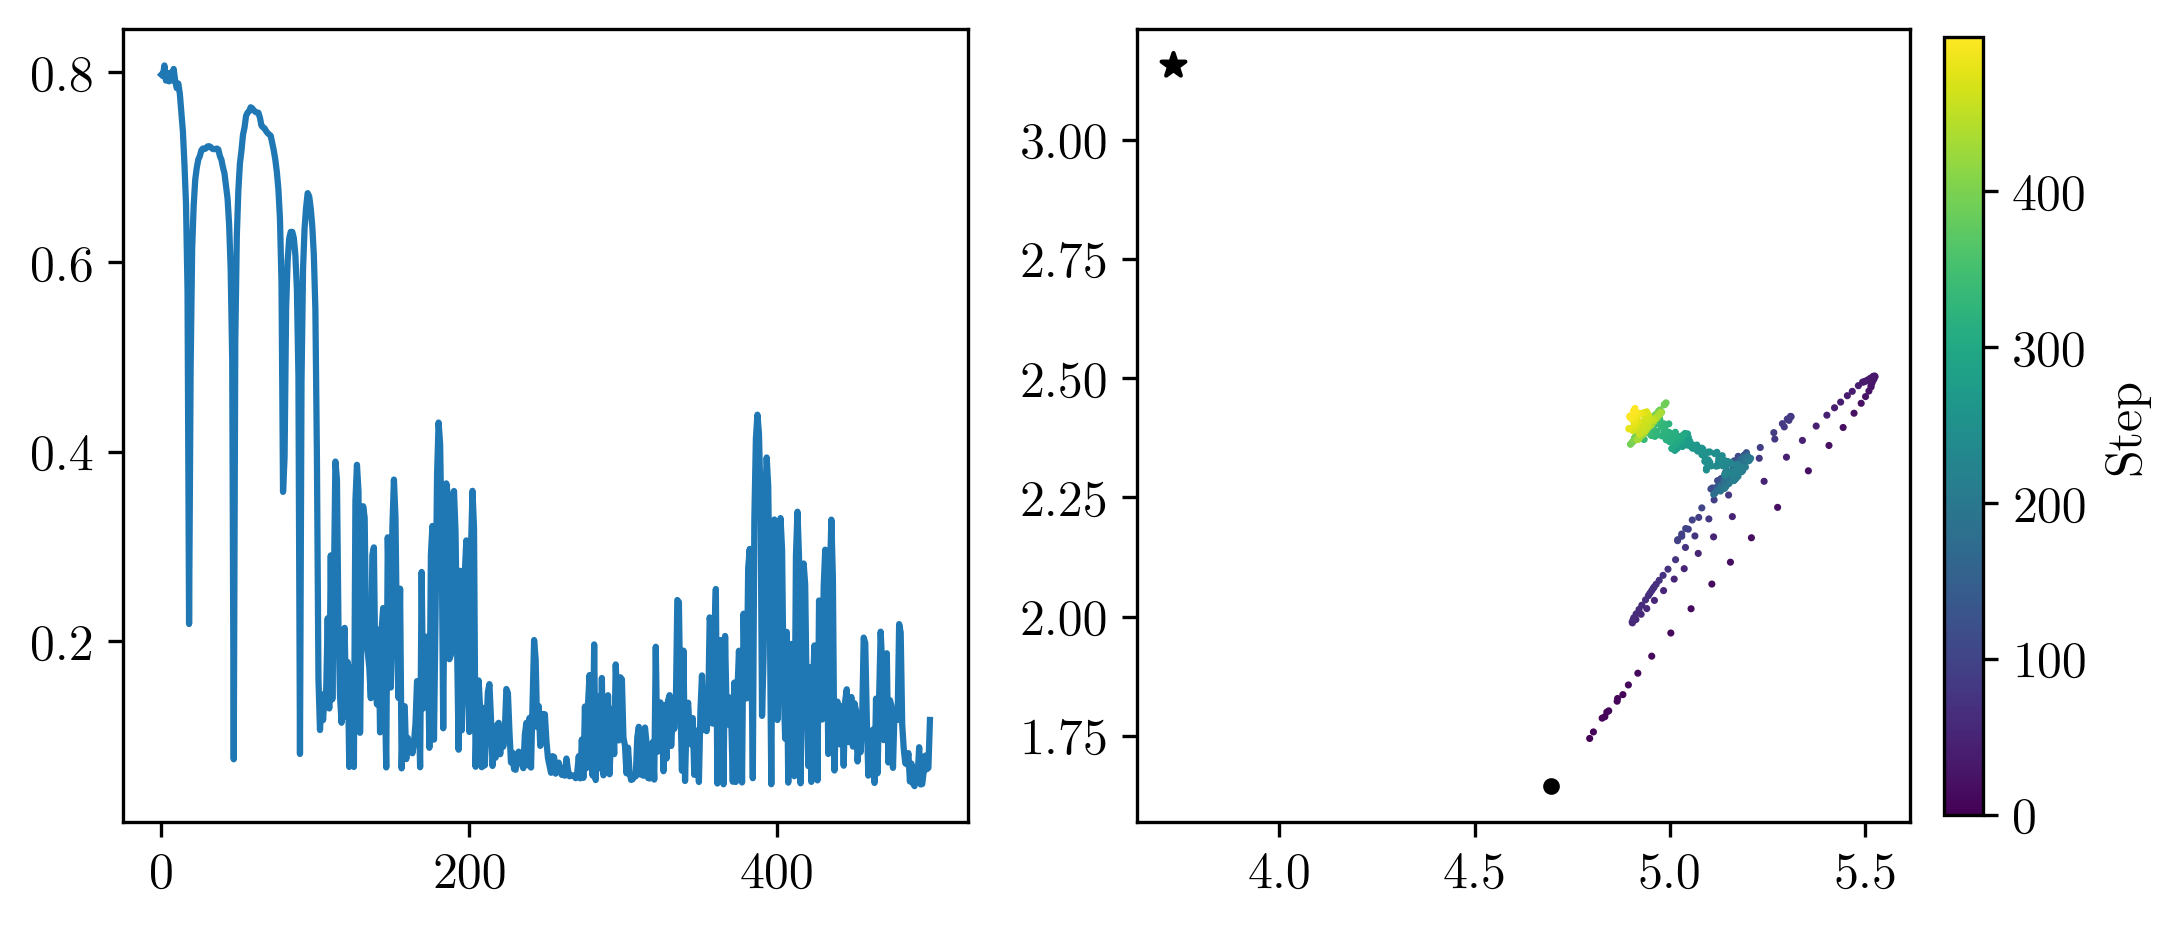

In [165]:
plt.figure(figsize=(8, 3.5))

plt.subplot(1, 2, 1)
plt.plot(mismatches)

plt.subplot(1, 2, 2)
plt.scatter(*thetas.T, s=0.5, c=jnp.arange(0, len(mismatches)))  # c=mismatches)
plt.colorbar(fraction=0.046, pad=0.04, label="Step")
# plt.plot(
#     [m_range[0], m_range[1], m_range[1], m_range[0]],
#     [m_range[0], m_range[0], m_range[1], m_range[0]],
#     "r",
#     linewidth=0.5,
# )
plt.scatter(*thetas[0], c="k", marker=".")
plt.scatter(*theta_true, c="k", marker="*")

In [167]:
mismatches.min()

DeviceArray(0.04748934, dtype=float64)

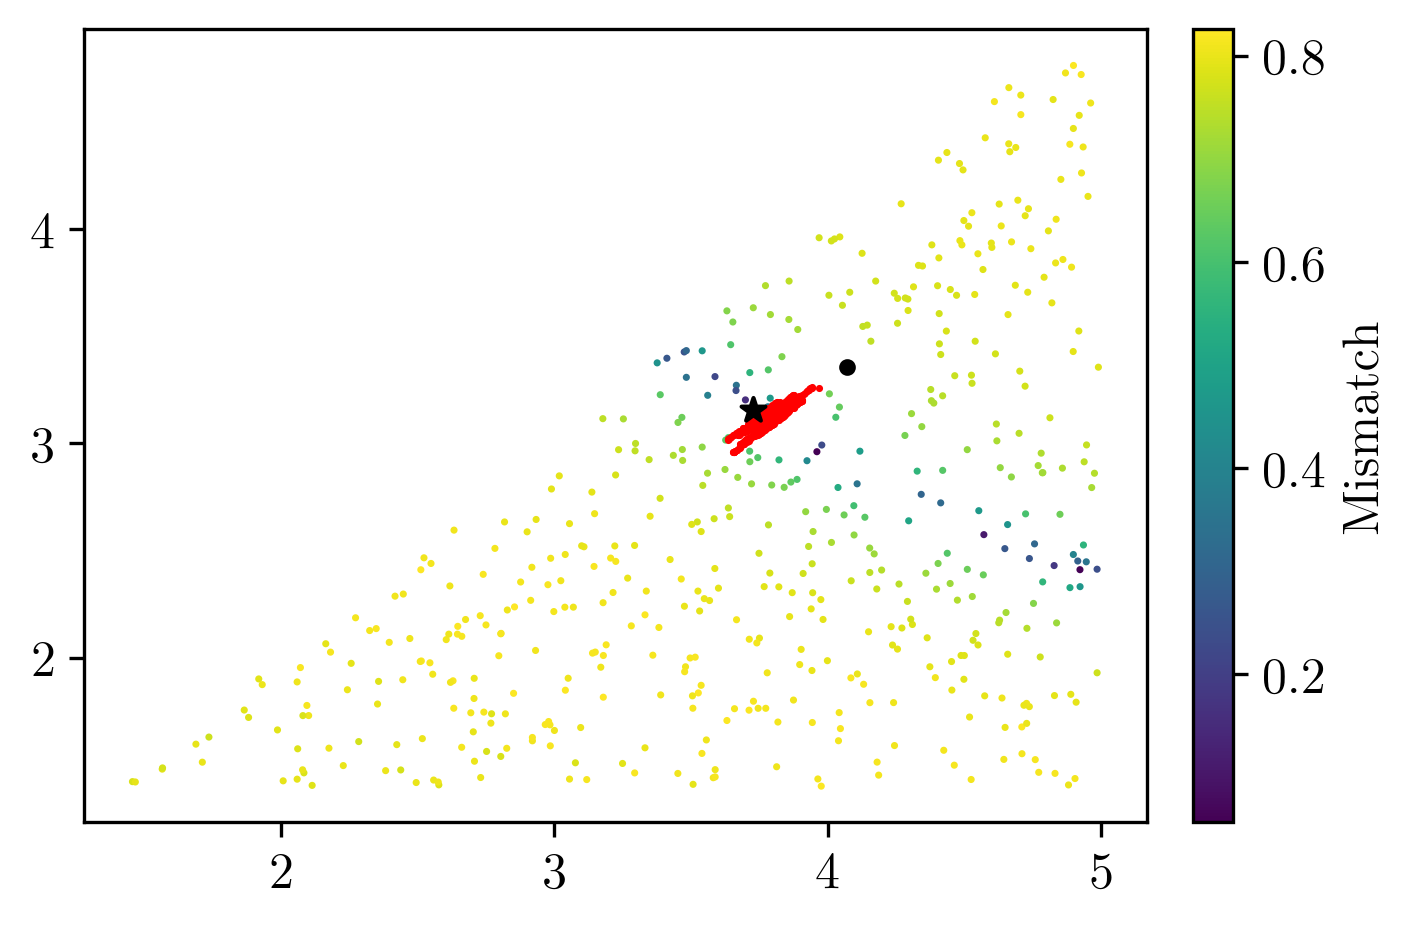

In [120]:
key, subkey = random.split(key)
theta_samples = sampler(subkey, 500)
plt.scatter(
    *theta_samples.T,
    s=0.5,
    c=jax.lax.map(lambda theta: mismatch_fun({"theta": theta}, theta_true), theta_samples)
)
plt.colorbar(label="Mismatch", fraction=0.046, pad=0.04)

plt.scatter(*thetas.T, s=0.5, c="r")
plt.scatter(*thetas[0], c="k", marker=".")
plt.scatter(*theta_true, c="k", marker="*")

## Second-order optimization
Newton's method: $x_{k+1} = x_k - \lambda \frac{f'(x_k)}{f''(x_k)}$

In [228]:
mismatch_fun = lambda theta: 1 - effectualness_fun(theta, theta_true)
grad_fun = jax.grad(mismatch_fun)
hessian_fun = hessian(mismatch_fun)

In [242]:
key, subkey = random.split(key)
theta0 = sampler(subkey, 1)[0]
# theta0 = jnp.array([4.5, 2.4])

In [243]:
res = minimize(
    mismatch_fun,
    theta0,
    method="trust-exact",
    jac=grad_fun,
    hess=hessian_fun,
    callback=print,
)

[4.55941679 1.517018  ]
[5.51796782 1.2320925 ]
[5.51796782 1.2320925 ]
[5.51796782 1.2320925 ]
[5.45653624 1.24362138]
[5.45653624 1.24362138]
[5.45653624 1.24362138]
[5.45653624 1.24362138]
[5.45651666 1.24386474]
[5.45651666 1.24386474]
[5.45651507 1.24380372]
[5.45645703 1.24382453]
[5.45645703 1.24382453]
[5.45644343 1.24381762]
[5.45643307 1.24382895]
[5.45643198 1.2438253 ]
[5.45642853 1.24382349]
[5.45642509 1.24382514]
[5.45641748 1.24382599]
[5.45640276 1.24383019]
[5.45637238 1.24383395]
[5.4563139 1.2438526]
[5.45619076 1.24385966]
[5.45619076 1.24385966]
[5.45619076 1.24385966]
[5.45619068 1.24386729]
[5.45619068 1.24386729]
[5.45619015 1.24387107]
[5.4561849  1.24387737]
[5.45617809 1.24387343]
[5.45617331 1.24387973]
[5.45616638 1.24387584]
[5.45616164 1.24388215]
[5.4561547  1.24387827]
[5.45614998 1.24388457]
[5.45614303 1.24388069]
[5.45613831 1.24388699]
[5.45613137 1.24388311]
[5.45612666 1.24388941]
[5.45611972 1.24388552]
[5.45611501 1.24389183]
[5.45610807 1.2438

[5.45442483 1.24423734]
[5.45442056 1.24424368]
[5.45441402 1.24423959]
[5.45440976 1.24424592]
[5.45440322 1.24424183]
[5.45439896 1.24424816]
[5.45439243 1.24424407]
[5.45438817 1.2442504 ]
[5.45438164 1.24424631]
[5.45437738 1.24425265]
[5.45437085 1.24424855]
[5.4543666  1.24425488]
[5.45436007 1.24425079]
[5.45435582 1.24425712]
[5.4543493  1.24425302]
[5.45434505 1.24425936]
[5.45433853 1.24425526]
[5.45433428 1.2442616 ]
[5.45432777 1.2442575 ]
[5.45432352 1.24426383]
[5.45431701 1.24425973]
[5.45431276 1.24426607]
[5.45430625 1.24426196]
[5.45430201 1.2442683 ]
[5.4542955 1.2442642]
[5.45429126 1.24427054]
[5.45428476 1.24426643]
[5.45428052 1.24427277]
[5.45427402 1.24426866]
[5.45426978 1.244275  ]
[5.45426329 1.24427089]
[5.45425905 1.24427723]
[5.45425256 1.24427311]
[5.45424832 1.24427946]
[5.45424183 1.24427534]
[5.45423759 1.24428168]
[5.45423111 1.24427757]
[5.45422688 1.24428391]
[5.4542204  1.24427979]
[5.45421616 1.24428614]
[5.45420969 1.24428202]
[5.45420545 1.2442

In [237]:
theta_true

DeviceArray([3.72677682, 3.15539282], dtype=float64)

In [229]:
key, subkey = random.split(key)
theta0 = sampler(subkey, 1)[0]
theta0 = jnp.array([4.5, 2.4])
thetas = [theta0]
mismatches = [mismatch_fun(theta0)]
lr = 0.5
with trange(2000) as pbar:
    for _ in pbar:
        # Take a step
        theta = thetas[-1]
        t = jnp.linalg.inv(hessian_fun(theta)) @ grad_fun(theta)
        theta = theta - lr * t
        # Update monitoring
        thetas.append(theta)
        mismatches.append(mismatch_fun(thetas[-1]))
        pbar.set_postfix_str(f"mismatch: {mismatches[-1]:.4f}")

thetas = jnp.array(thetas)
mismatches = jnp.array(mismatches)

  0%|          | 0/2000 [00:00<?, ?it/s]

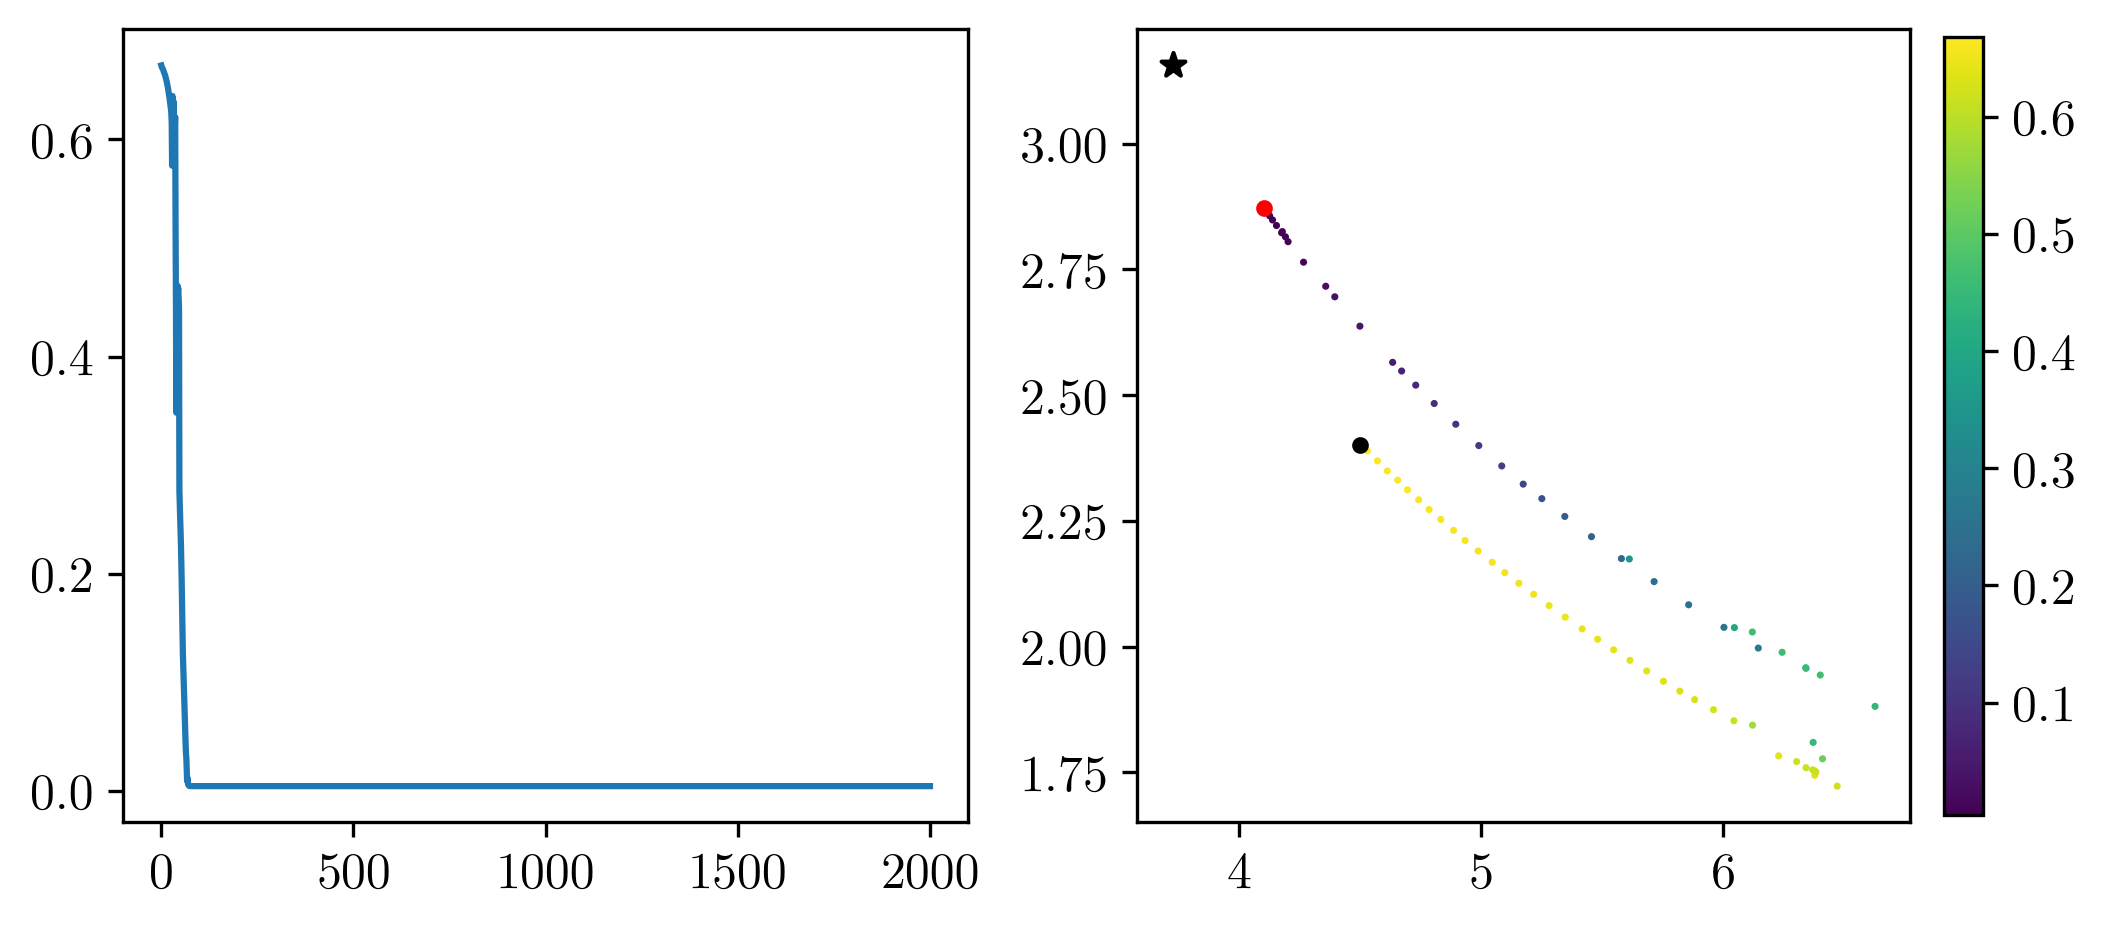

In [232]:
plt.figure(figsize=(8, 3.5))

plt.subplot(1, 2, 1)
plt.plot(mismatches)

plt.subplot(1, 2, 2)
plt.scatter(*thetas.T, s=0.5, c=mismatches)  # c=jnp.arange(0, len(mismatches))
plt.colorbar(fraction=0.046, pad=0.04)

plt.scatter(*thetas[0], c="k", marker=".")
plt.scatter(*thetas[-1], c="r", marker=".")
plt.scatter(*theta_true, c="k", marker="*")

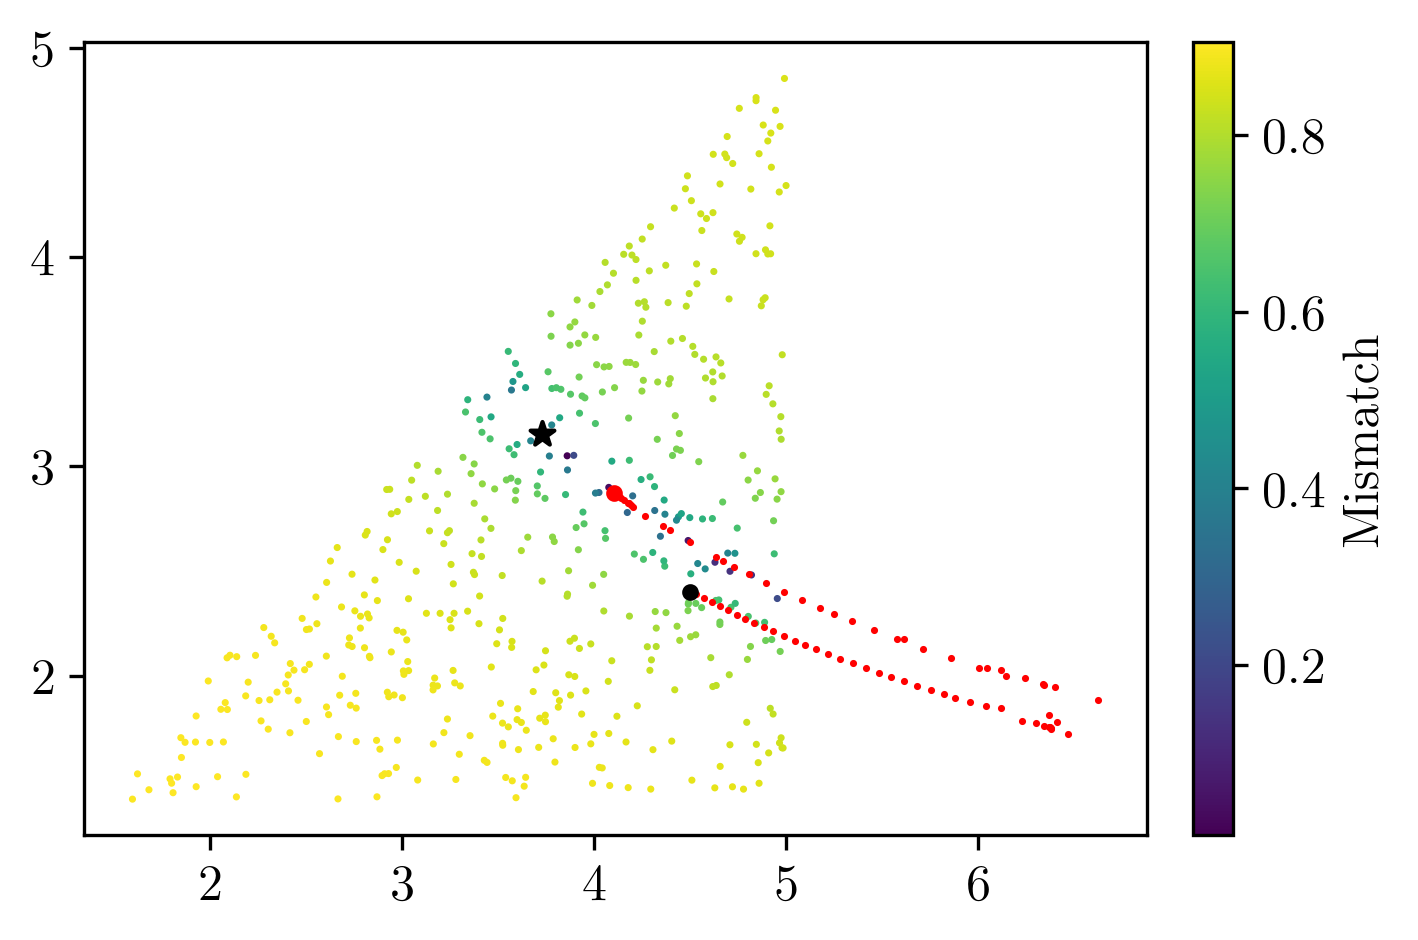

In [233]:
key, subkey = random.split(key)
theta_samples = sampler(subkey, 500)
plt.scatter(*theta_samples.T, s=0.5, c=jax.lax.map(mismatch_fun, theta_samples))
plt.colorbar(label="Mismatch", fraction=0.046, pad=0.04)

plt.scatter(*thetas.T, s=0.5, c="r")
plt.scatter(*thetas[0], c="k", marker=".")
plt.scatter(*thetas[-1], c="r", marker=".")
plt.scatter(*theta_true, c="k", marker="*")

## Bounded optimization
Solutions are out of bounds. Not sure how to control this.

In [137]:
from scipy.optimize import Bounds, LinearConstraint, minimize

In [145]:
bounds = Bounds(m_range, m_range)
linear_constraint = LinearConstraint([[-1, 1]], [-jnp.inf], [0])

In [146]:
mismatch_fun = lambda theta: 1 - effectualness_fun(theta, theta_true)
grad_fun = jax.grad(mismatch_fun)
hessian_fun = hessian(mismatch_fun)

In [158]:
key, subkey = random.split(key)
# theta0 = sampler(subkey, 1)[0]
theta0 = theta_true + 0.2
res = minimize(
    mismatch_fun,
    theta0,
    method="trust-constr",
    jac=grad_fun,
    hess=hessian_fun,
    constraints=[linear_constraint],
    options={"verbose": 1, "initial_constr_penalty": 10},
    bounds=bounds,
)

`xtol` termination condition is satisfied.
Number of iterations: 280, function evaluations: 54, CG iterations: 0, optimality: 9.31e-10, constraint violation: 1.20e+00, execution time:  3.3 s.


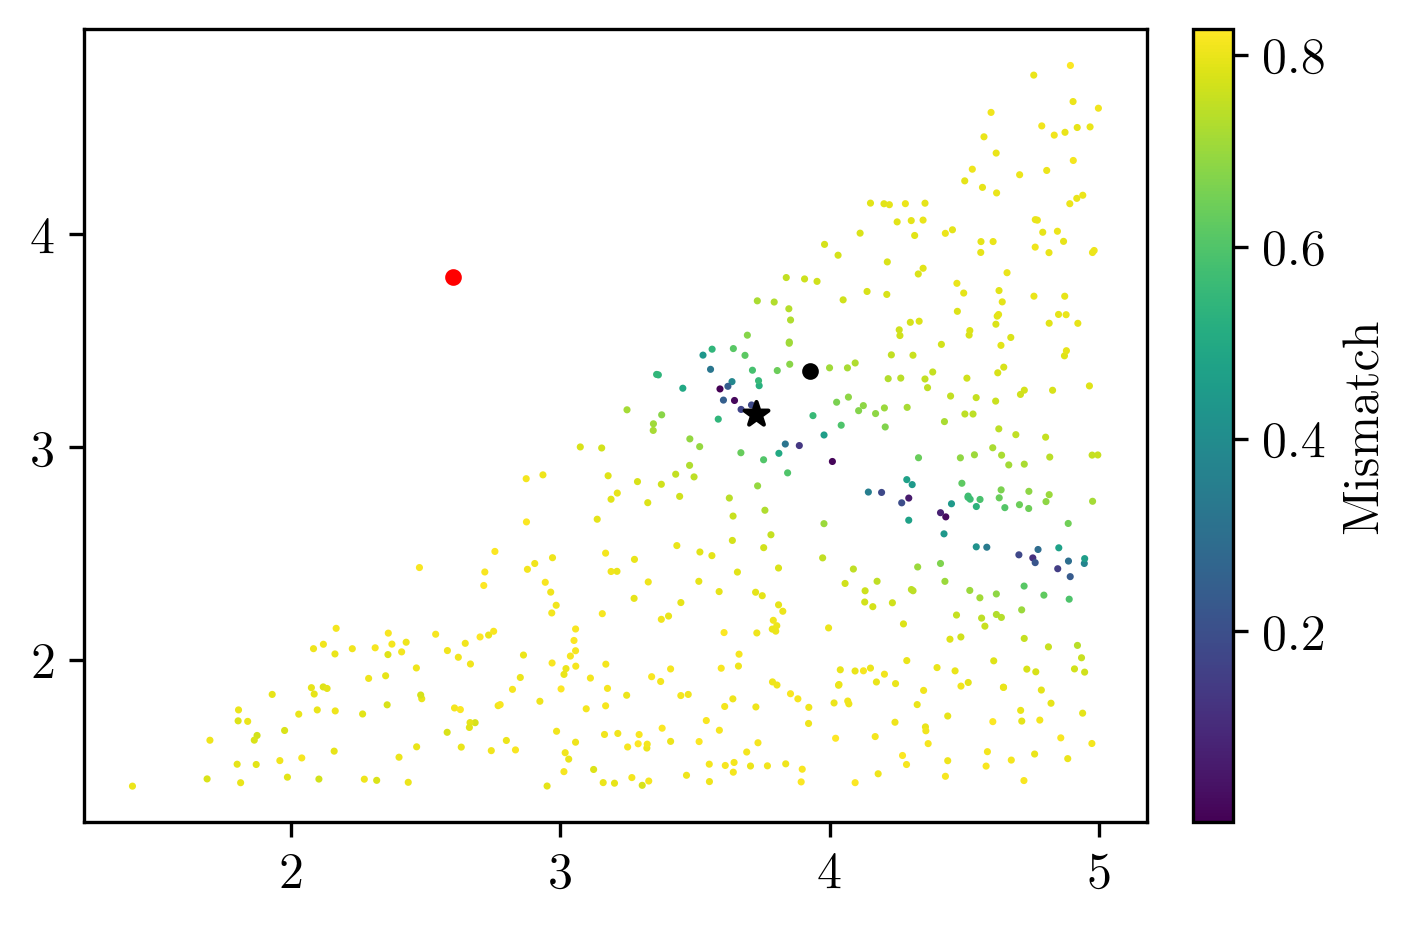

In [159]:
key, subkey = random.split(key)
theta_samples = sampler(subkey, 500)
plt.scatter(*theta_samples.T, s=0.5, c=jax.lax.map(mismatch_fun, theta_samples))
plt.colorbar(label="Mismatch", fraction=0.046, pad=0.04)

plt.scatter(*theta0, c="k", marker=".")
plt.scatter(*res.x, c="r", marker=".")
plt.scatter(*theta_true, c="k", marker="*")